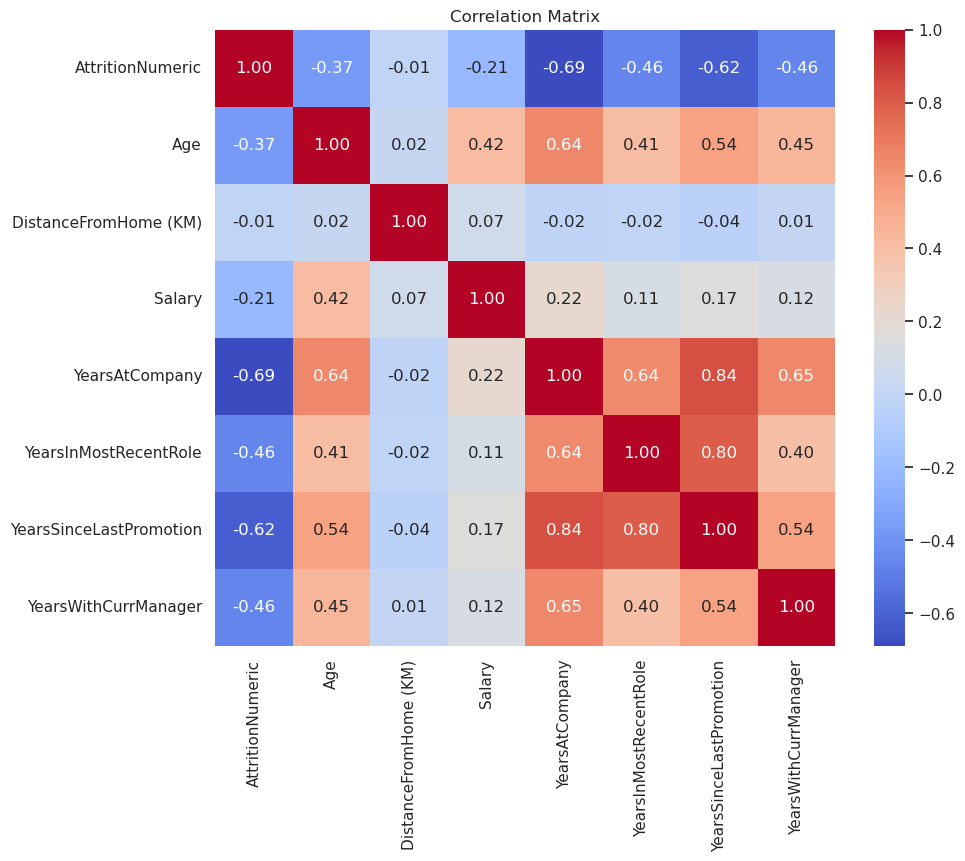

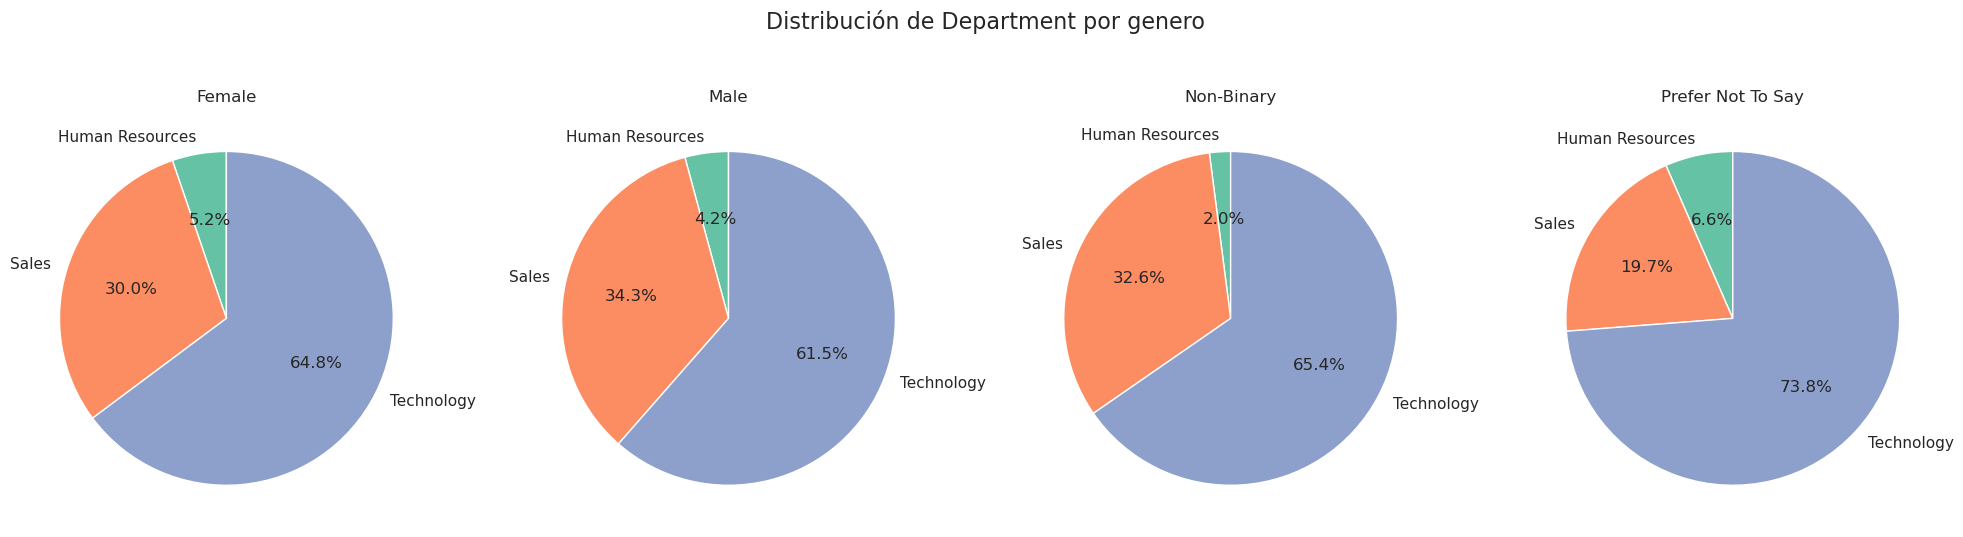

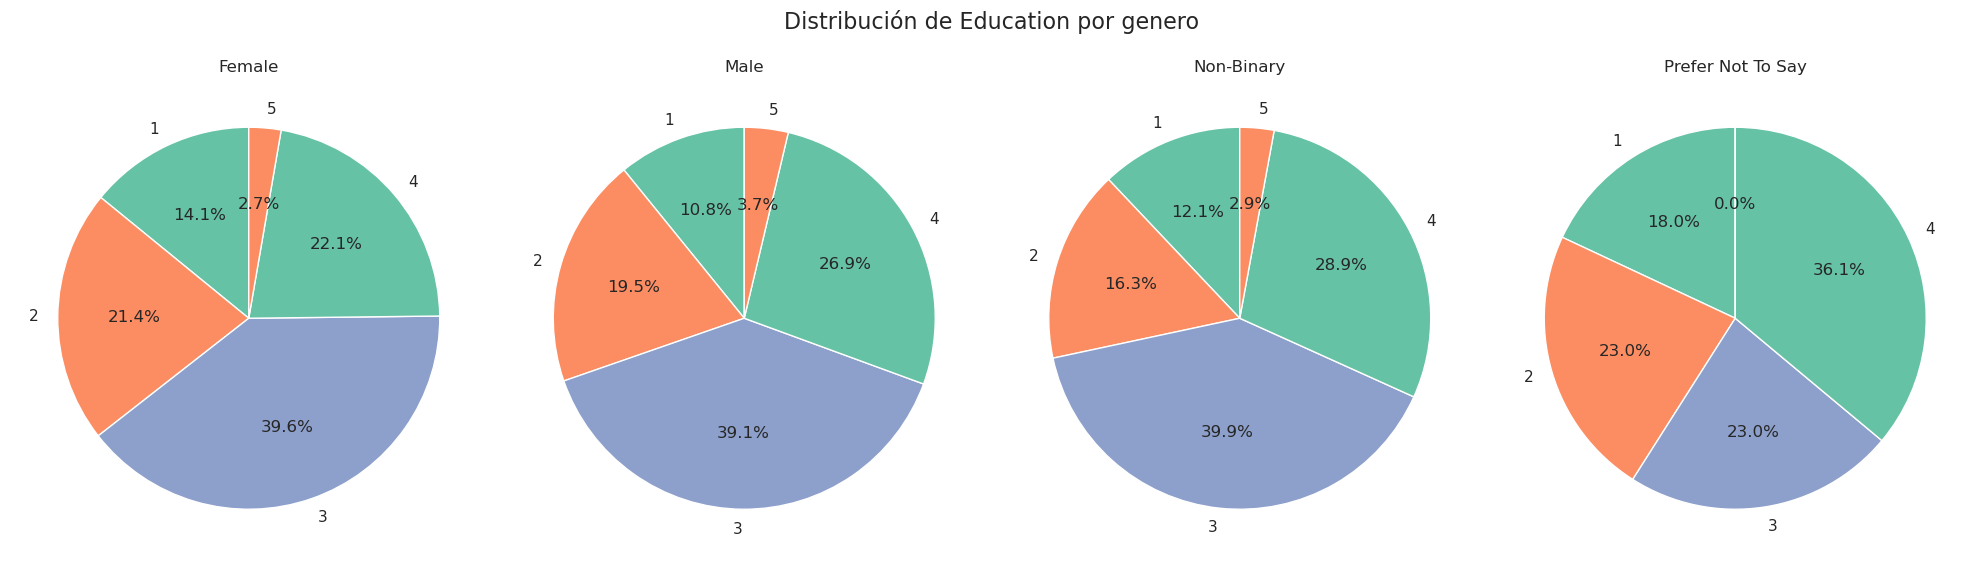

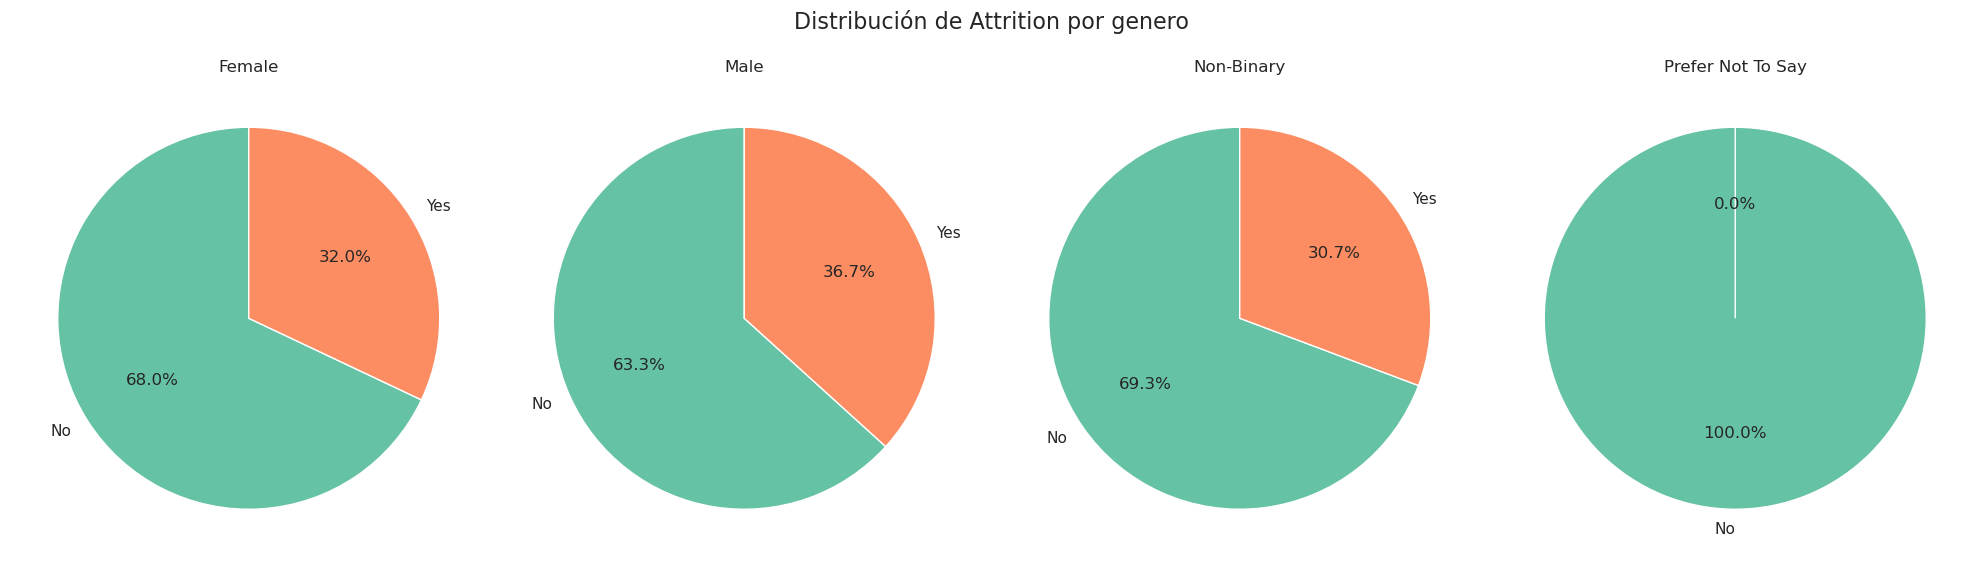

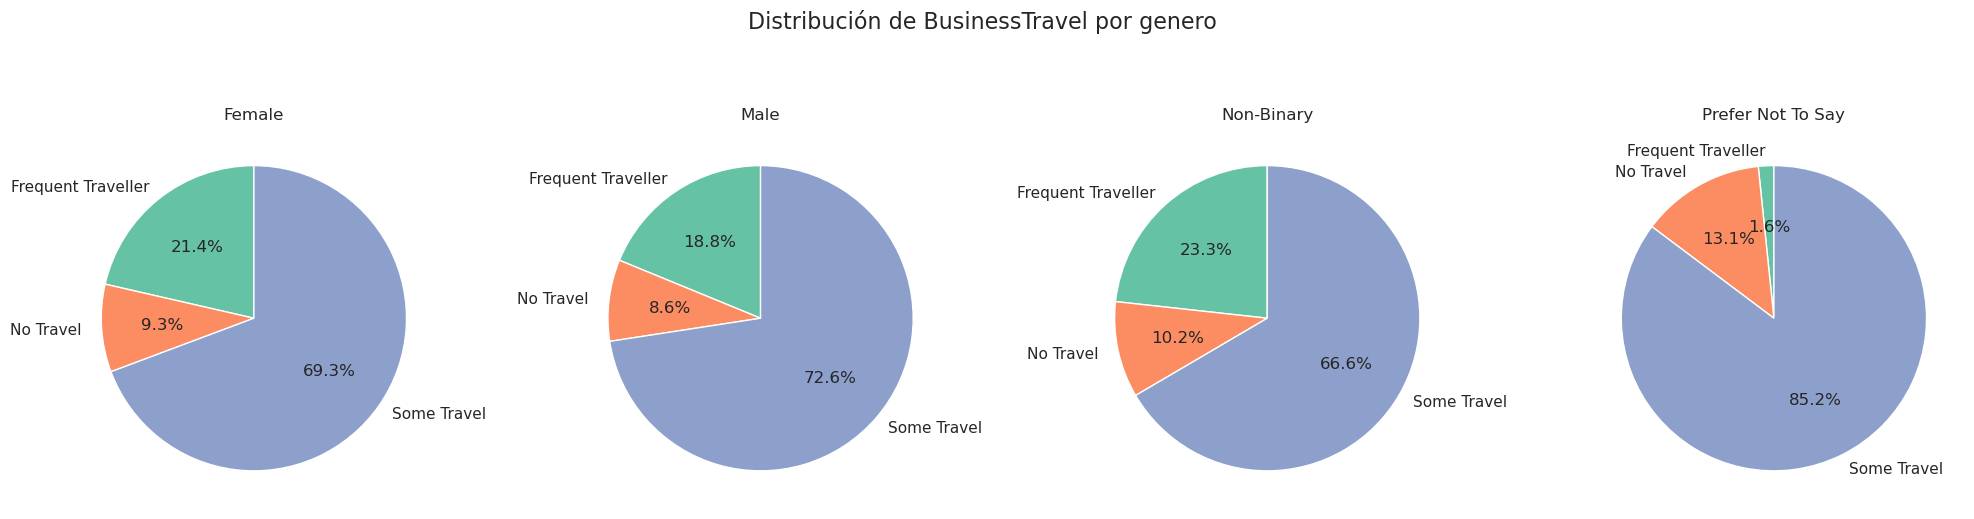

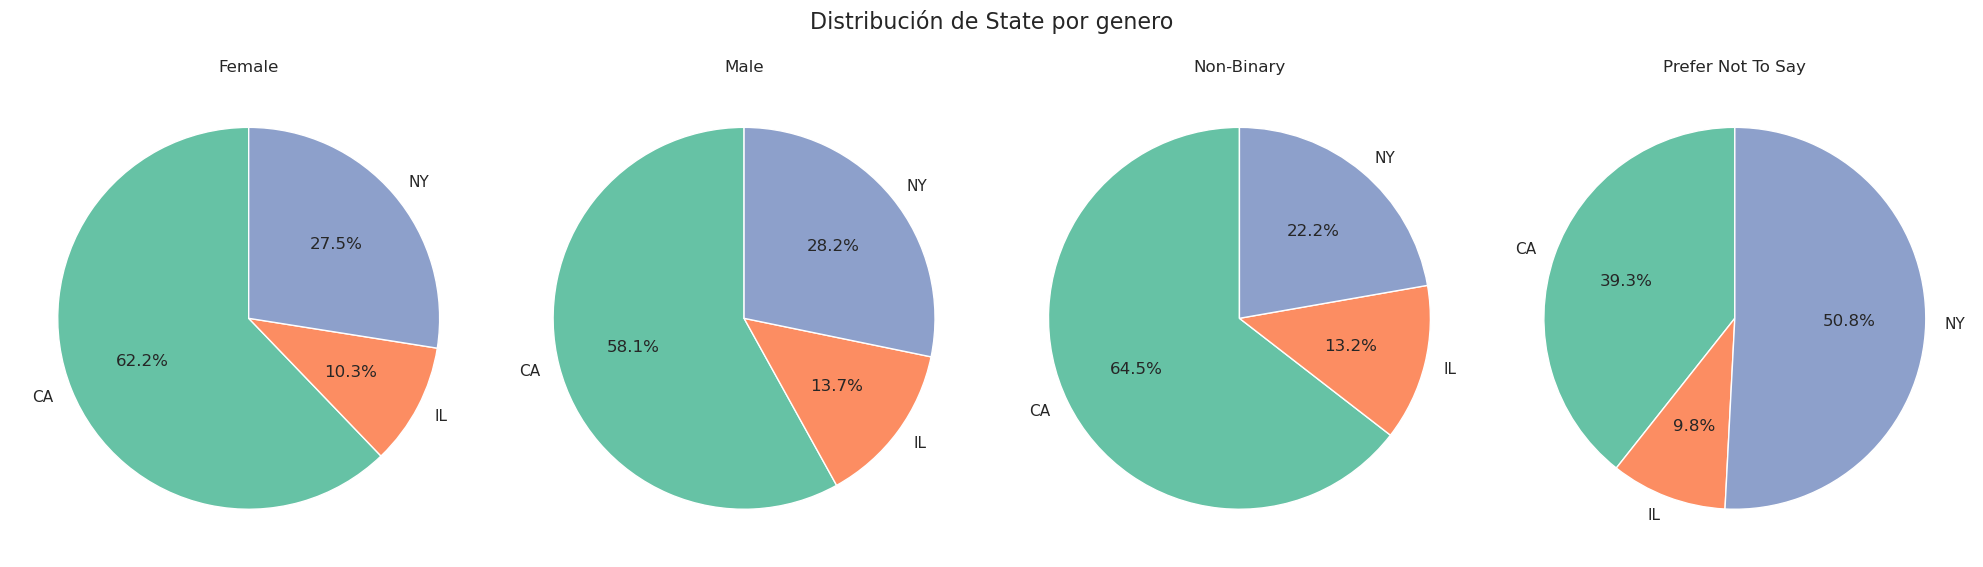

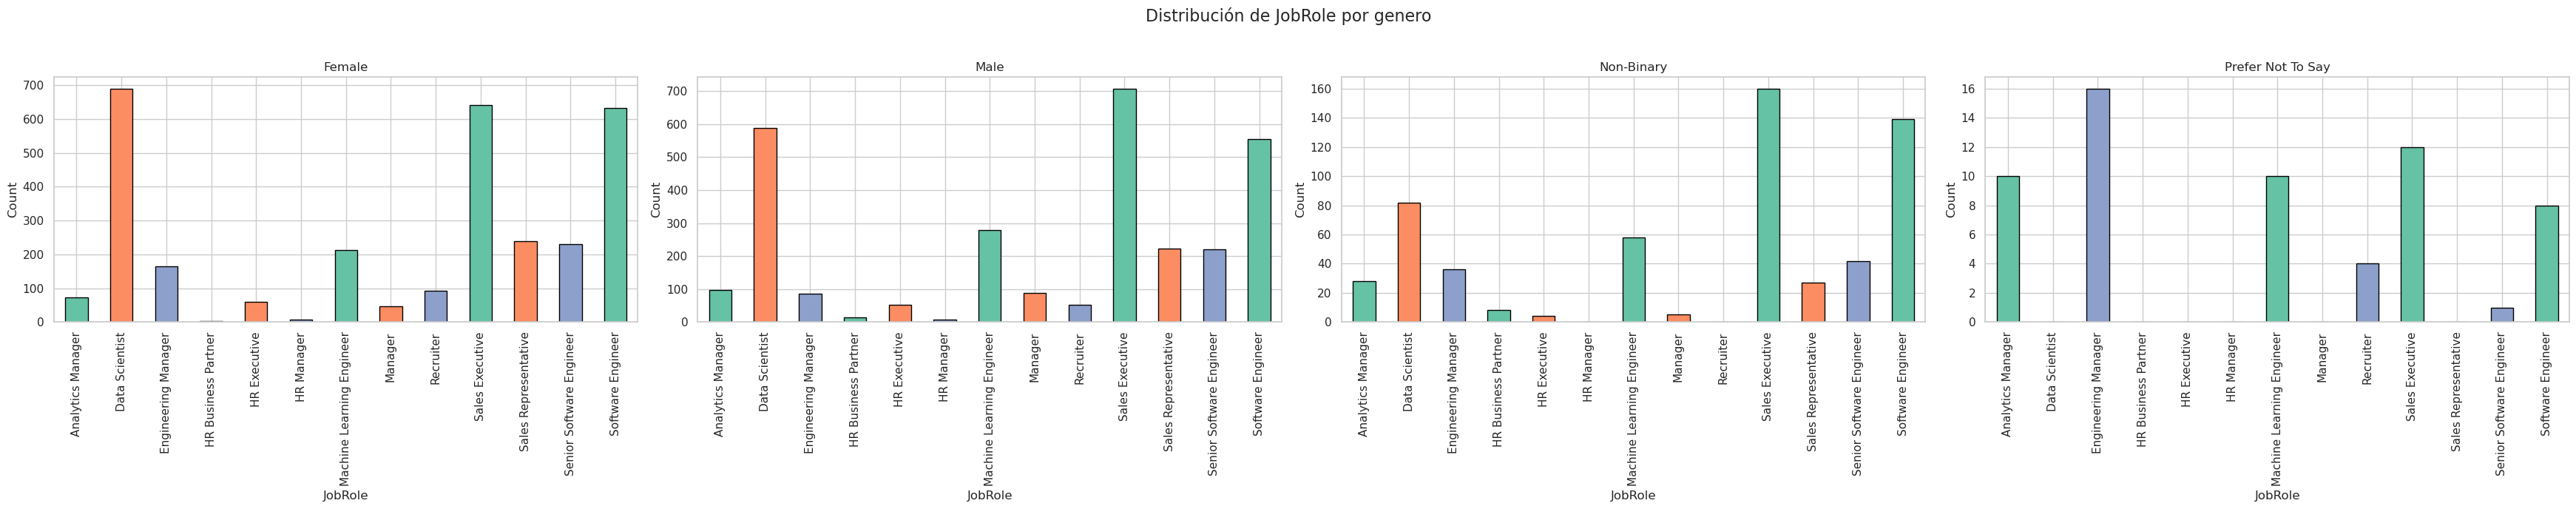

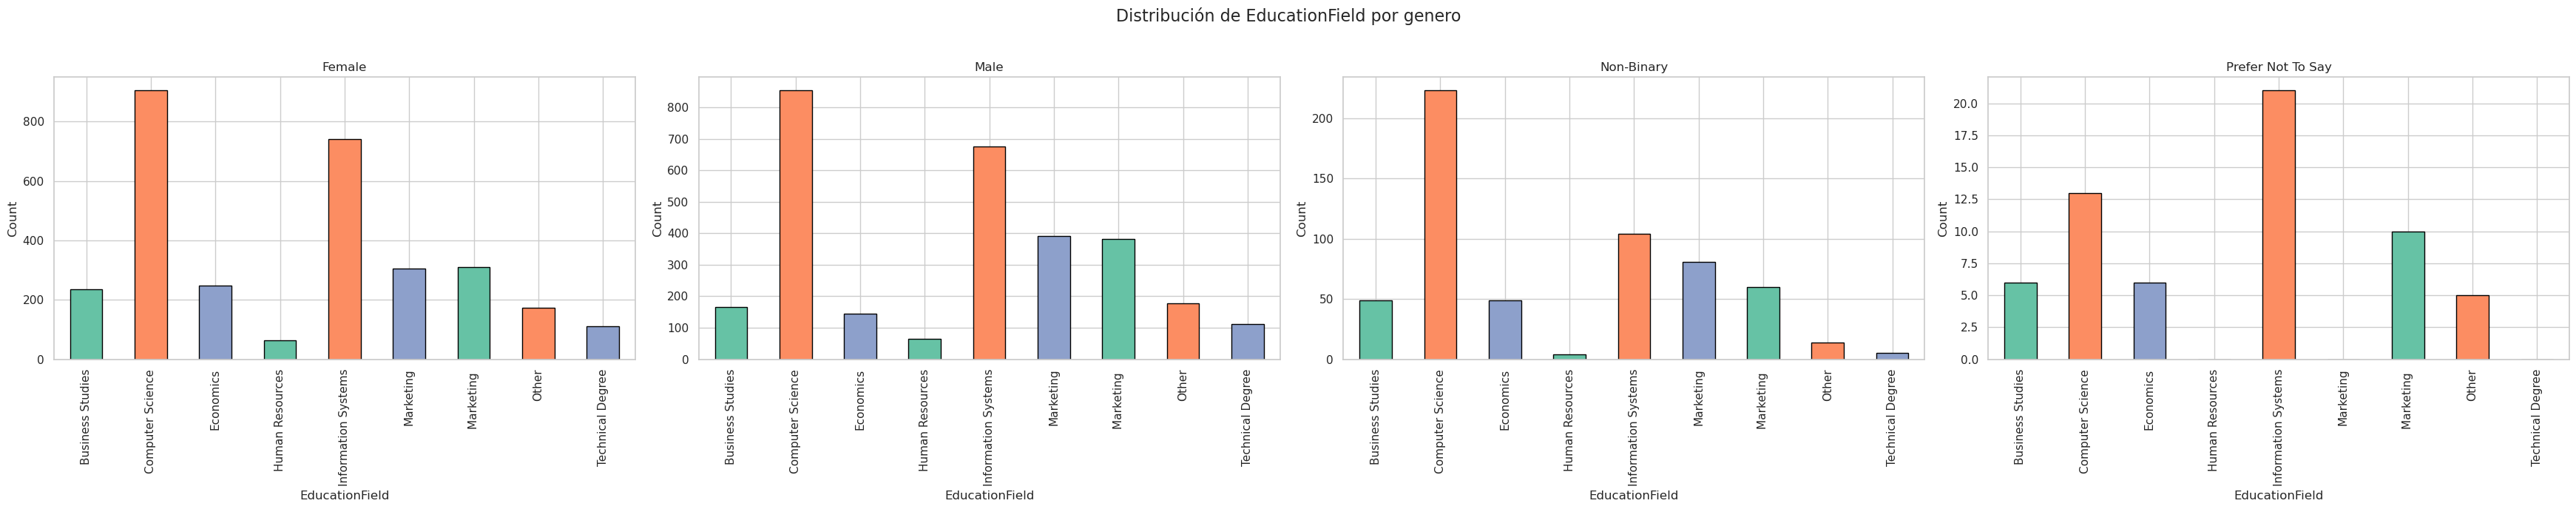

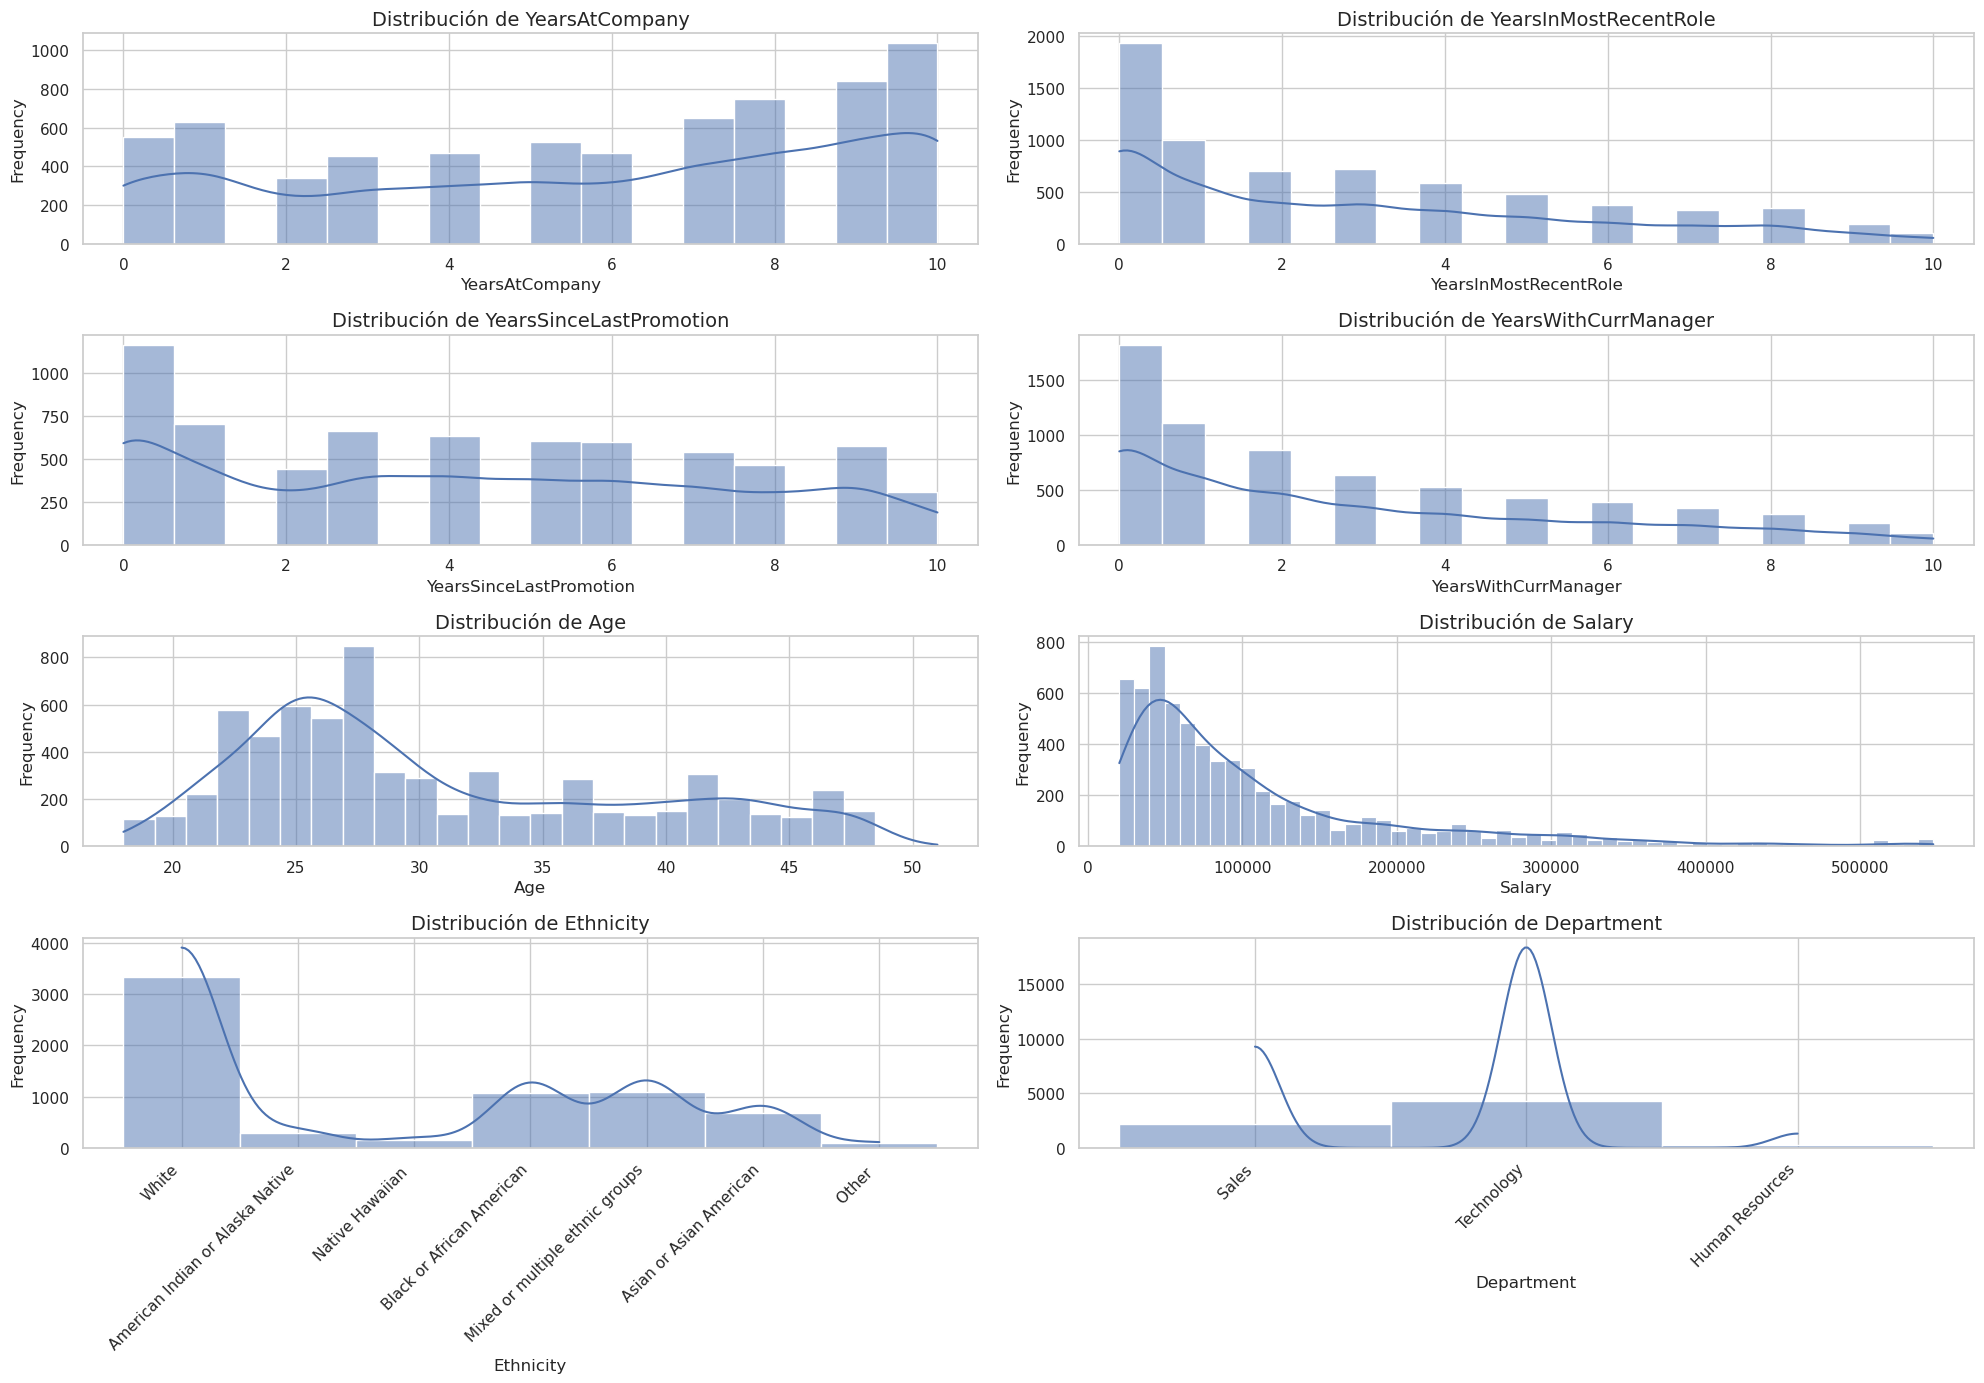

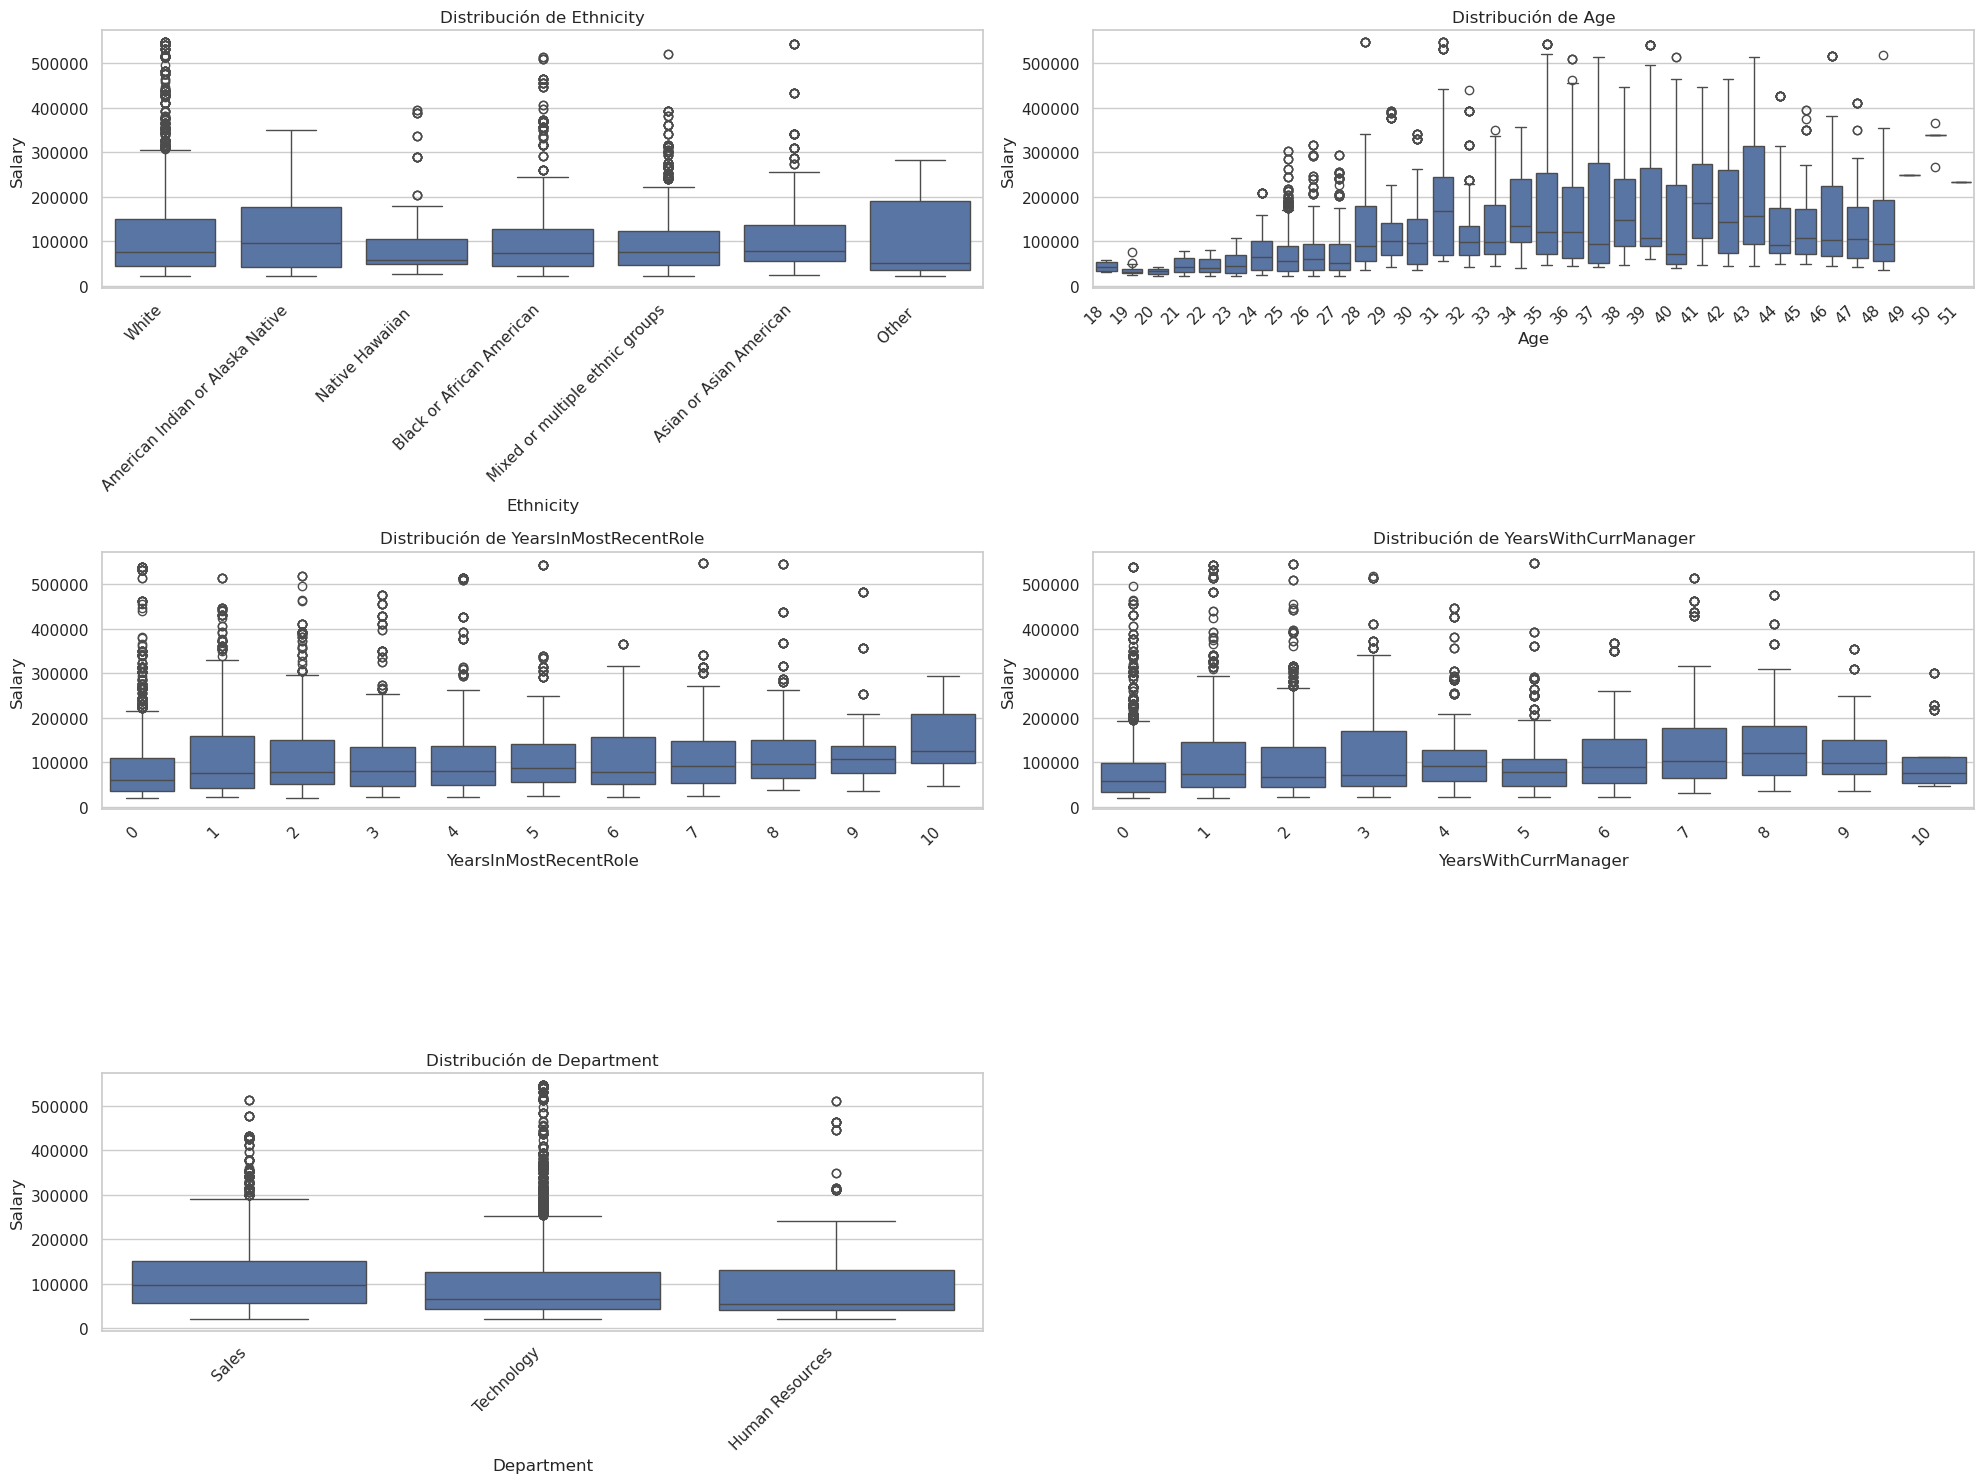

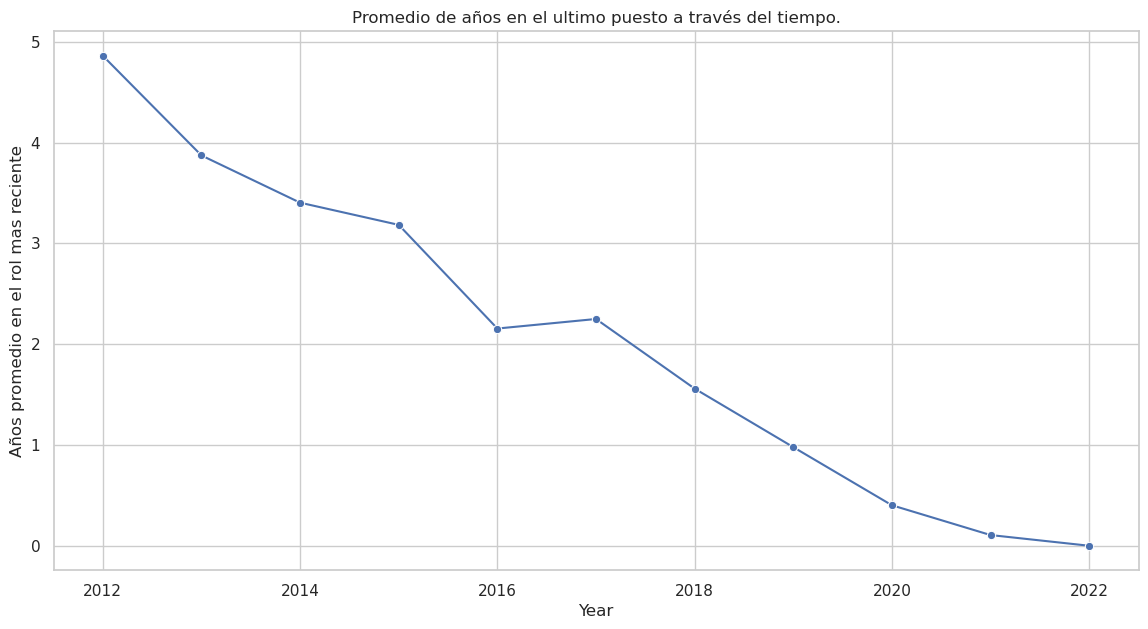

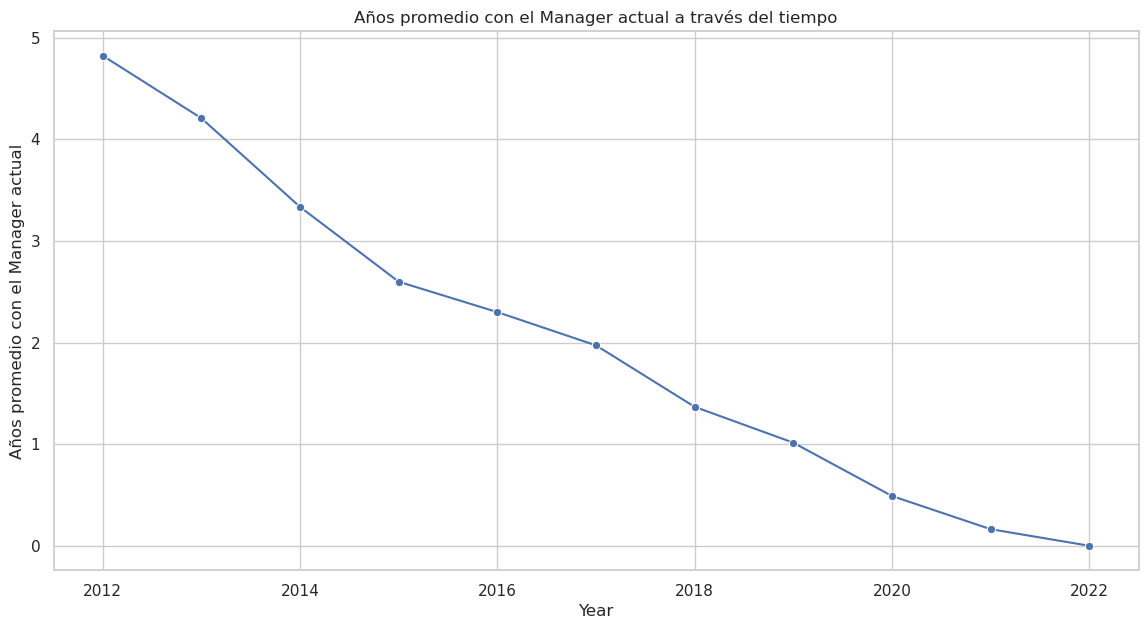

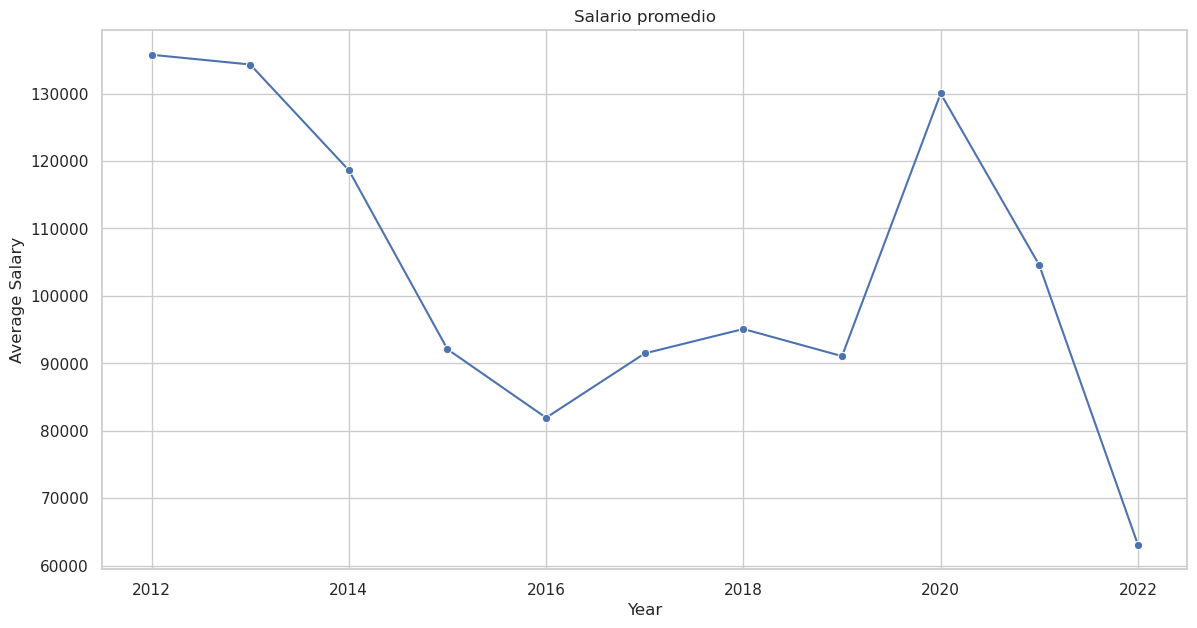

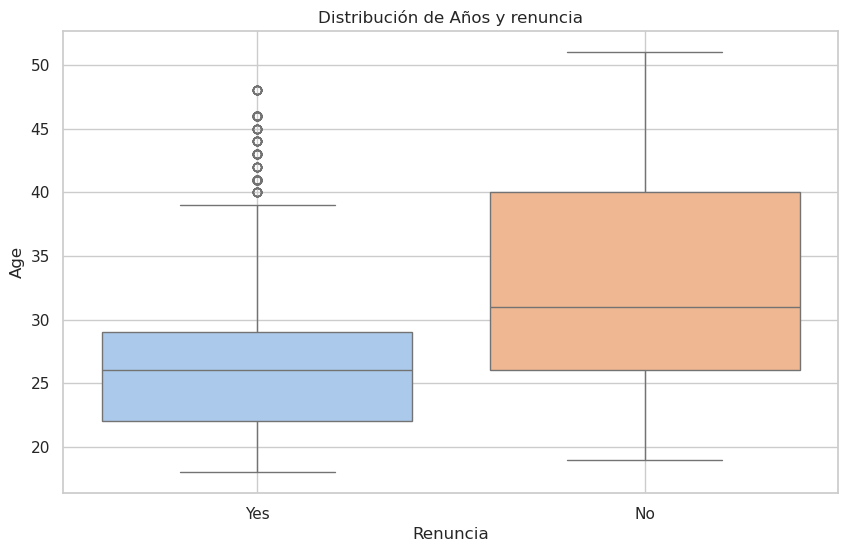

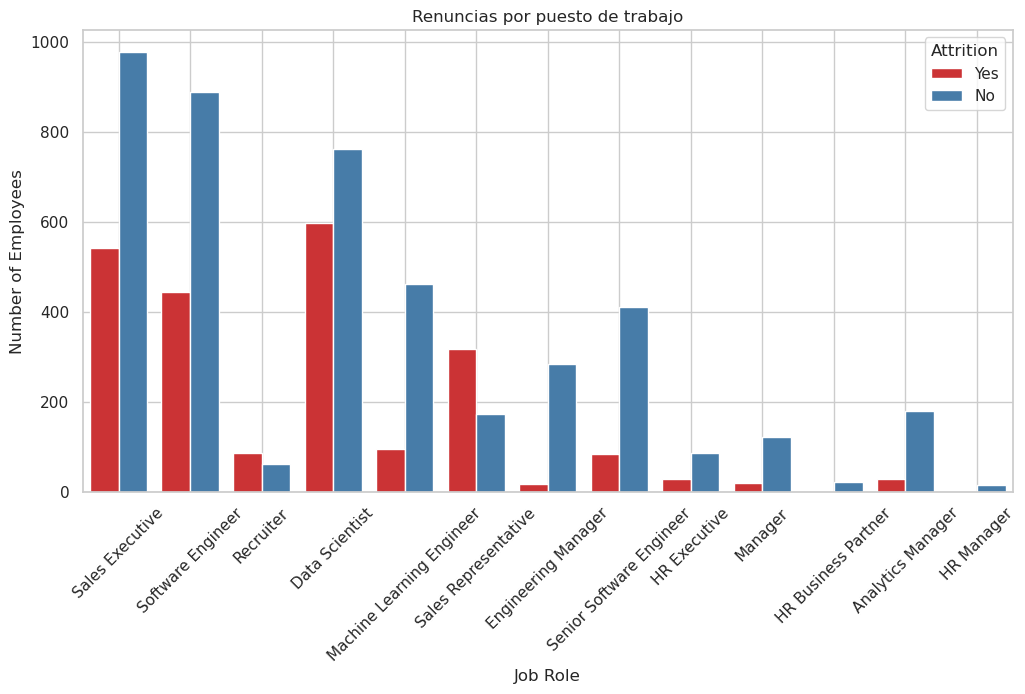

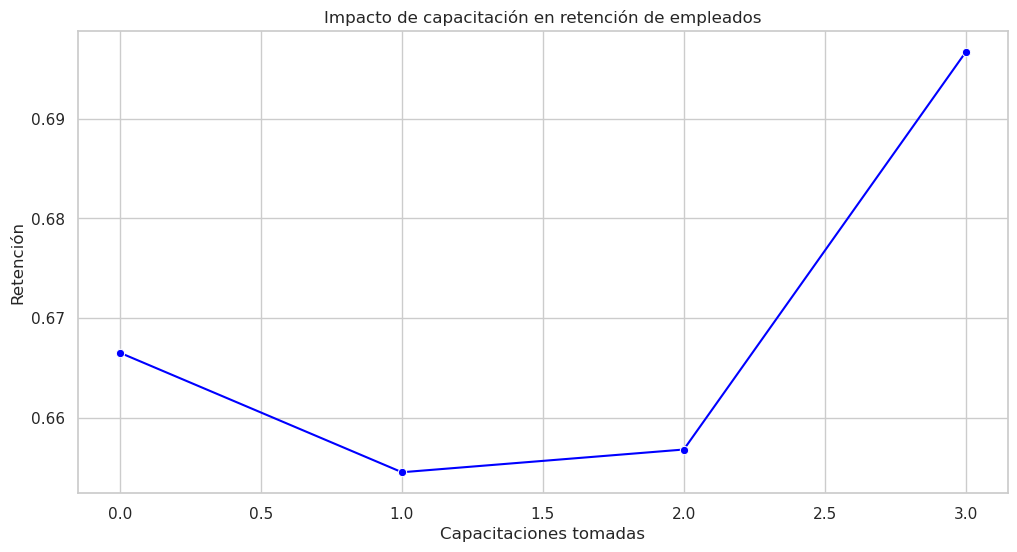

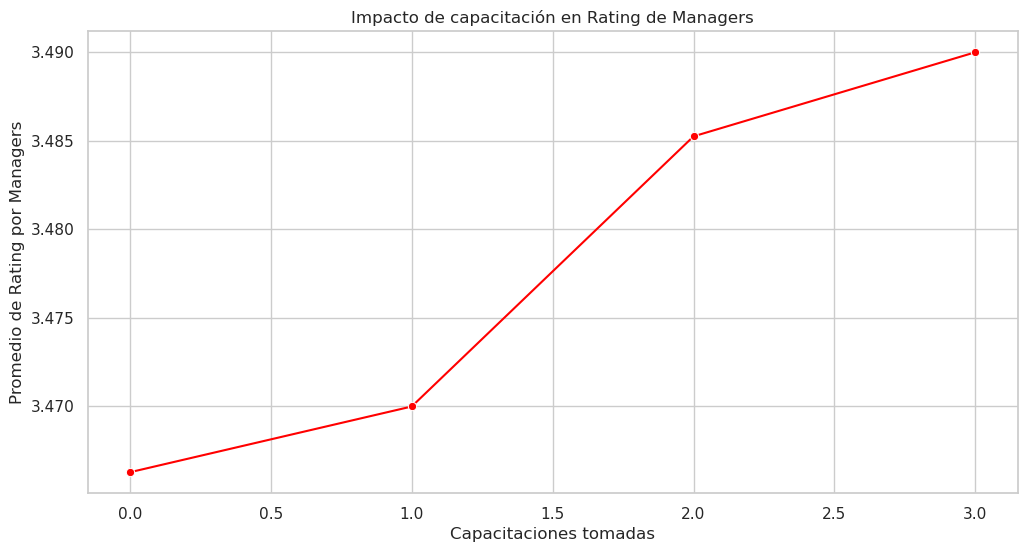

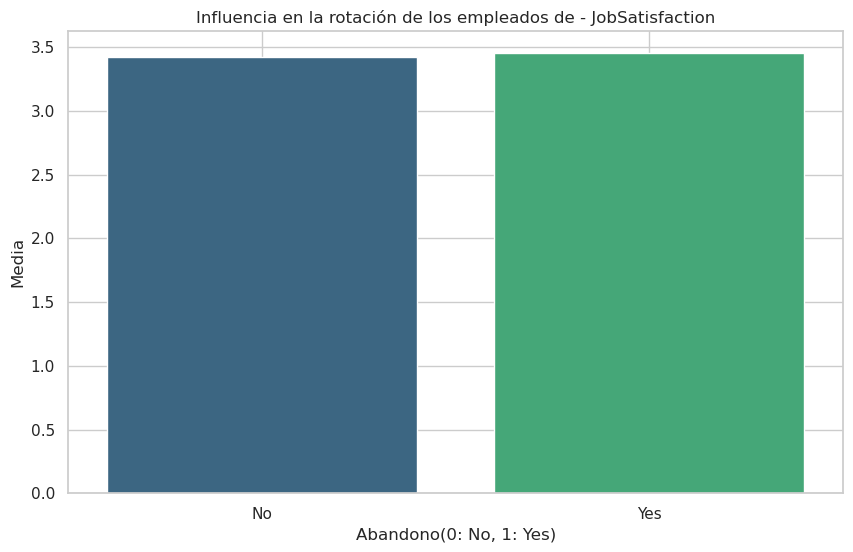

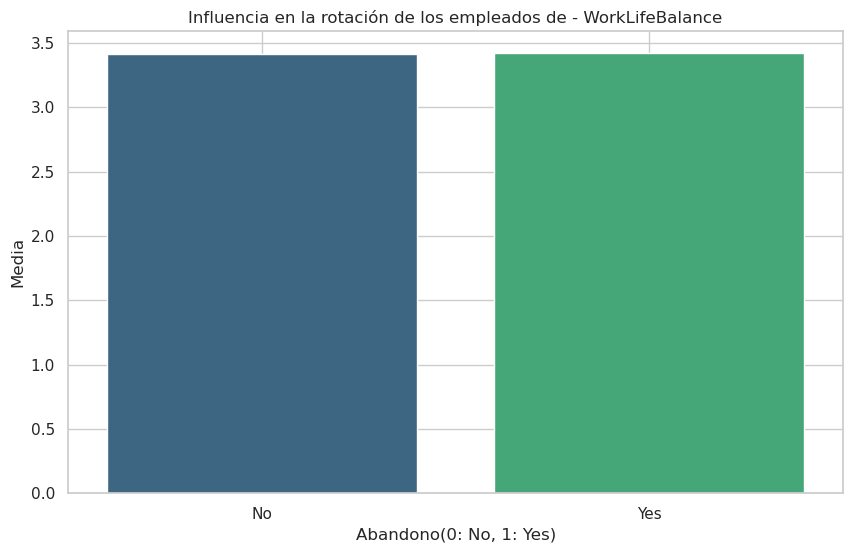

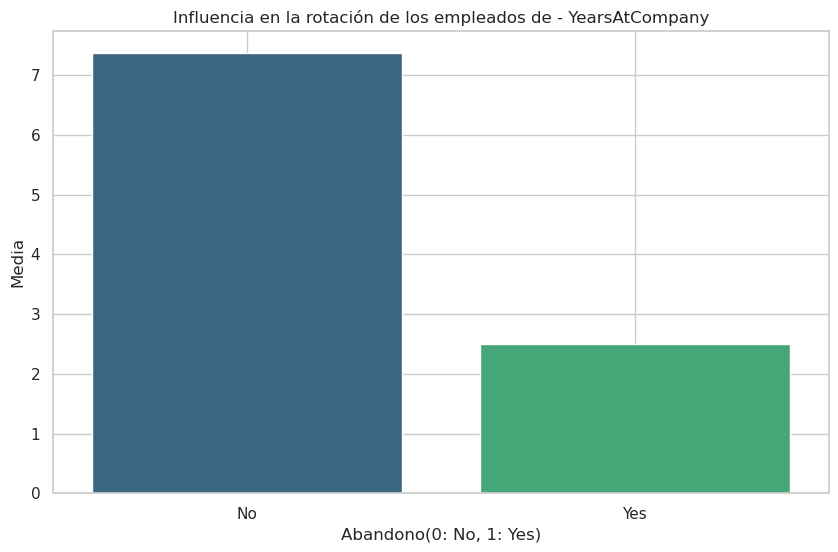

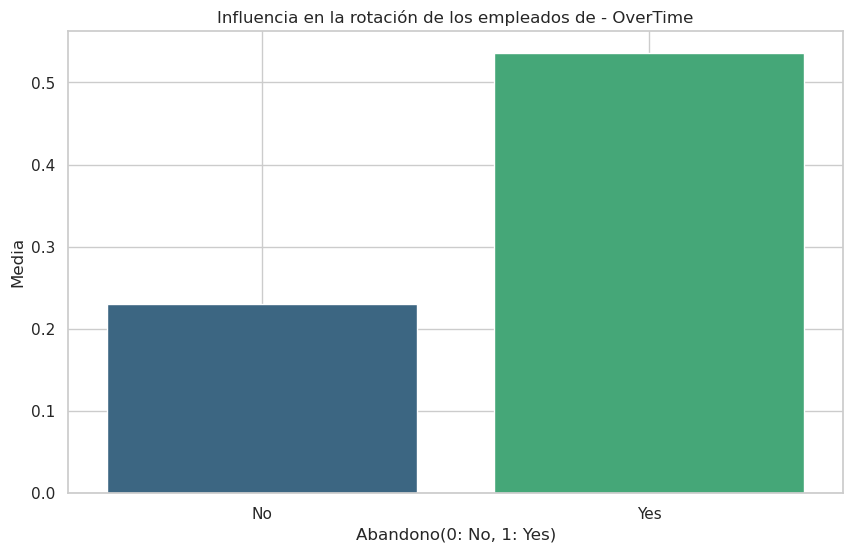

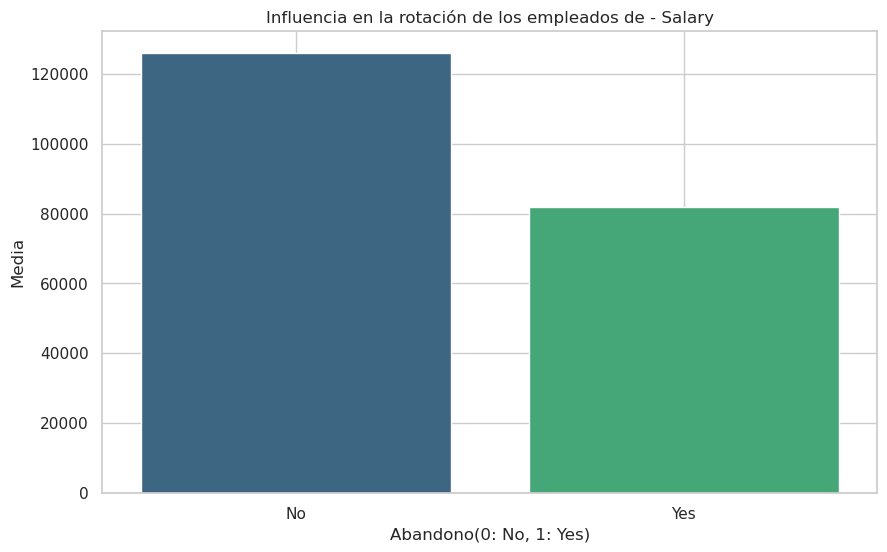

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Cargar y procesar datos
employee = pd.read_csv('Employee.csv')
performance = pd.read_csv('PerformanceRating.csv')
data = pd.merge(performance, employee, on='EmployeeID')

data['JobSatisfaction'] = pd.to_numeric(data['JobSatisfaction'], errors='coerce')
data['WorkLifeBalance'] = pd.to_numeric(data['WorkLifeBalance'], errors='coerce')
data['YearsAtCompany'] = pd.to_numeric(data['YearsAtCompany'], errors='coerce')
data['OverTime'] = data['OverTime'].map({'Yes': 1, 'No': 0})
data['Salary'] = pd.to_numeric(data['Salary'], errors='coerce')
data['AttritionNumeric'] = data['Attrition'].map({'Yes': 1, 'No': 0})

# Funciones Helper
def plot_correlation_matrix(df, cols):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

def plot_pie_chart_by_gender(df, feature):
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), subplot_kw=dict(aspect="equal"))
    grouped_data = df.groupby([feature, 'Gender']).size().unstack().T
    for ax, (gender, data) in zip(axes, grouped_data.iterrows()):
        data.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
        ax.set_title(gender)
        ax.set_ylabel('')
    plt.suptitle(f'Distribución de {feature} por genero', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_bar_chart_by_gender(df, feature):
    fig, axes = plt.subplots(1, 4, figsize=(35, 7))
    grouped_data = df.groupby([feature, 'Gender']).size().unstack().T
    for ax, (gender, data) in zip(axes, grouped_data.iterrows()):
        data.plot(kind='bar', ax=ax, color=['#66c2a5', '#fc8d62', '#8da0cb'], edgecolor='black')
        ax.set_title(gender)
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
    plt.suptitle(f'Distribución de {feature} por genero', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_feature_distributions(df, features):
    n_cols = 2
    n_rows = (len(features) + n_cols - 1) // n_cols
    plt.figure(figsize=(20, 14))
    for i, feature in enumerate(features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribución de {feature}', fontsize=14)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        if feature in ['Ethnicity', 'Department']:
            plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_salary_distribution(df, features):
    plt.figure(figsize=(20, 15))
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 2, i)
        sns.boxplot(x=feature, y='Salary', data=df)
        plt.title(f'Distribución de {feature}')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel(feature)
        plt.ylabel('Salary')
    plt.tight_layout()
    plt.show()

def plot_time_series(df, column, title, ylabel):
    df['HireDate'] = pd.to_datetime(df['HireDate'])
    yearly_data = df.groupby(df['HireDate'].dt.year).agg({column: 'mean'}).reset_index()
    plt.figure(figsize=(14, 7))
    sns.lineplot(x='HireDate', y=column, data=yearly_data, marker='o')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Gráficas
plot_correlation_matrix(data, ['AttritionNumeric'] + ['Age', 'DistanceFromHome (KM)', 'Salary', 'YearsAtCompany', 'YearsInMostRecentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'])

for feature in ['Department', 'Education', 'Attrition', 'BusinessTravel', 'State']:
    plot_pie_chart_by_gender(data, feature)

for feature in ['JobRole', 'EducationField']:
    plot_bar_chart_by_gender(data, feature)

plot_feature_distributions(data, ['YearsAtCompany', 'YearsInMostRecentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Age', 'Salary', 'Ethnicity', 'Department'])

plot_salary_distribution(data, ['Ethnicity', 'Age', 'YearsInMostRecentRole', 'YearsWithCurrManager', 'Department'])

plot_time_series(data, 'YearsInMostRecentRole', 'Promedio de años en el ultimo puesto a través del tiempo.', 'Años promedio en el rol mas reciente')
plot_time_series(data, 'YearsWithCurrManager', 'Años promedio con el Manager actual a través del tiempo', 'Años promedio con el Manager actual')
plot_time_series(data, 'Salary', 'Salario promedio', 'Average Salary')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='Age', data=data, hue='Attrition', palette='pastel', legend=False)
plt.title('Distribución de Años y renuncia')
plt.xlabel('Renuncia')
plt.ylabel('Age')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='JobRole', hue='Attrition', data=data, palette='Set1')
plt.title('Renuncias por puesto de trabajo')
plt.xlabel('Job Role')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

retention_analysis = data.groupby('TrainingOpportunitiesTaken').agg({
    'Attrition': lambda x: (x == 'No').mean(),
    'ManagerRating': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=retention_analysis, x='TrainingOpportunitiesTaken', y='Attrition', marker='o', color='blue')
plt.title('Impacto de capacitación en retención de empleados')
plt.xlabel('Capacitaciones tomadas')
plt.ylabel('Retención')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=retention_analysis, x='TrainingOpportunitiesTaken', y='ManagerRating', marker='o', color='red')
plt.title('Impacto de capacitación en Rating de Managers')
plt.xlabel('Capacitaciones tomadas')
plt.ylabel('Promedio de Rating por Managers')
plt.grid(True)
plt.show()

attrition_factors = data.groupby('Attrition')[['JobSatisfaction', 'WorkLifeBalance', 'YearsAtCompany', 'OverTime', 'Salary']].mean().reset_index()
for column in ['JobSatisfaction', 'WorkLifeBalance', 'YearsAtCompany', 'OverTime', 'Salary']:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Attrition', y=column, data=attrition_factors, palette='viridis', hue='Attrition', legend=False)
    plt.title(f'Influencia en la rotación de los empleados de - {column}')
    plt.xlabel('Abandono(0: No, 1: Yes)')
    plt.ylabel('Media')
    plt.grid(True)
    plt.show()